Adrian Swartz and Alfred Cheung<br>
4/8/2019<br>

# Analysis Code for "Superconducting Tunneling Spectroscopy of Spin-Orbit Coupling and Orbital Depairing in Nb:SrTiO$_3$"

This is the source code for the analysis of spin-orbit coupling and orbital depairing in thin Nb-doped SrTiO$_3$ thin films as measured by electron tunneling spectroscopy. This code was used for the data analysis presented in [Swartz, et al., Physical Review Letters __121__, 167003 (2018)](https://doi.org/10.1103/PhysRevLett.121.167003), and also available on the [arxiv](https://arxiv.org/abs/1805.00047). A couple of example calculations are presented here in a Jupyter Notebook for the purpose of demonstrating the code in operation. Lasly, the numerical solutions to Maki's theory is implemented here in python 2.

Complete details on the experimental measurements and physics of spin-orbit coupling are provided in the published manuscript. Here, I briefly summarize the physics and math relevant for computing the best fit according to Maki's theory for the spin-resolved density of states (DOS) of a superconductor. The tunneling current is given by integrating the DOS over the experimental bias window ($eV$). Tuning the voltge (the energy ($E$)) between a counter electrode and the sample enables a direct measurement of the differential conductance ($di/dv$) (proportional to the sample DOS). The complete DOS is the sum of the two spin-components as given by,<br>
$\begin{equation}
\label{Maki1}
\rho_{\uparrow,\downarrow} = \frac{\rho_0}{2} \,\textrm{Re} \! \left( \frac{u_{\pm}}{\sqrt{u_{\pm}^2 - 1}}   \right),
\end{equation}
%$
where $\rho_0$ is the normal-state DOS and $u_{\pm}$ are defined by,
$
% 
\begin{equation}
\label{Maki2}
u_{\pm} = \frac{E\mp \mu_B H}{\Delta_0} + 
\zeta \frac{u_{\pm}}{\sqrt{1-u_{\pm}^2}} +
b \left(    \frac{u_{\mp}-u_{\pm}}{\sqrt{1-u_{\mp}^2}}    \right).
\end{equation}
$<br>
Here, $E$ is the experimental energy, $\mu_B$ is the Bohr magneton, $H$ is the applied magnetic field, $\Delta_0$ is the energy of the superconducting gap, $\zeta = \alpha_i + \alpha_o H_{\parallel}^2$ is the total contribution to orbital depairing including both the field-dependent orbital depairing parameter ($\alpha_o$) and the intrinsic depairing term ($\alpha_i=0.056$), and lastly $b$ is the dimensionless spin-orbit mixing rate. Note that $b$ is dimensionless, while $\alpha_o$ has units of T$^{-2}$. The two free parameters in the fit are $\alpha_o$ and $b$, while the magnetic field and temperature are fixed by the experimental environment. The size of the superconducting gap ($\Delta_0$) is deterimined at zero magnetic field. 

This is the recursive formula for the spin-resolved density of states as originally given by Maki. Early experiments on elemental superconductors by Tedrow and Meservey in the 1970's employed Maki's theory conceptually and qualitatively, but did not provide detailed computational procedure. More "recently," Alexander provided a set of four equations with four complex unknowns which is equivalent to Maki's equation which was used to explore Fermi liquid effects on the superconducting DOS and tunneling spectrum. Alexender's approach simplifies the problem to solving a set of complex (real and imaginary) linear equations. This numerical approach was applied as a proof of concept to the problem of spin-split superconducting tunneling spectra by Wordledge and Geballe for Al superconducting contacts to thin LSMO films. Wordledge and Geballe work demonstrated that this numeriacal analysis method was valid in the low spin-orbit limit (for a single magnetic field). 

Here, I have adopted the approach presented by Worledge and Geballe for superconducting tunneling spectra of SrTiO$_3$ thin films in the 2D superconducting limit. In this case, the spin-orbit coupling strength cannot assume to be weak. An applied magnetic field breaks the superconducting Cooper pairs apart (destroying the superconducting phase) by the combination of orbital depairing and spin-orbit mixing. In the limit of strong spin-orbit coupling, these two processes both manifest as effective broadening of the superconducting gap. The spin-orbit coupling and orbital depairing contributions cannot therefore be independently quantified when there is finite spin-orbit coupling. Therefor, much of the published paper details focuses on carefully quantifying the experimental limits which can be placed on $\alpha_o$ and $b$. 

Even though the model parameters ($\alpha_o$ and $b$) have a complex and non-linear relationship with the dependent variable $E$, this is still essentially a regression problem. The solution to the set of four complex equations is calculated at each energy and the function `dosarray_filter` in the `DOSMODEL_class` ensures smoothness of the local minima of the density of states accross the entire energy range. The metric for the quality of the fit to the data is the mean squared error integrated (and normalized) over the energy range. Further details are available in the main text and supplementary materials of the [published manuscript](https://doi.org/10.1103/PhysRevLett.121.167003). 

In [1]:
#import libraries
import numpy as np
import cmath as cm
from scipy.optimize import minimize
from scipy.optimize import fsolve
import pylab as pl

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp = sns.color_palette()

In [2]:
class TOSOLVE_class:
    """ create the set of 8 non-linear equations (4 real and 4 imaginary)
    E is just a parameter (not an array)
    creates the 4 equations to be solved for a specific energy (could be positive or negative)
    E, delta, alphaorb, alphasoc, and h are all single parameters
    """

    def __init__(self,E,Delta,alphaorb,alphasoc,h):
        self.Delta = Delta
        self.alphaorb = alphaorb
        self.alphasoc = alphasoc
        self.h = h
        self.E = E

    def func(self,x):
        # returns a list of 8 equesions; first 4 are real, the final 4 are the imaginary piece
        return [\
        self.E*x[2]+x[0]+self.h**2*x[6]-self.alphaorb*(x[0]*x[2]-x[1]*x[3]-self.h**2*x[4]*x[6]+self.h**2*x[5]*x[7])/np.pi,\
        self.E*x[3]+x[1]+self.h**2*x[7]-self.alphaorb*(x[0]*x[3]+x[1]*x[2]-self.h**2*x[4]*x[7]-self.h**2*x[5]*x[6])/np.pi,\
        self.E*x[6]+x[2]-x[4]+self.alphaorb*(x[2]*x[4]-x[3]*x[5]-x[0]*x[6]+x[1]*x[7])/np.pi-self.alphasoc*(x[0]*x[6]-x[1]*x[7]+x[2]*x[4]-x[3]*x[5])/np.pi,\
        self.E*x[7]+x[3]-x[5]+self.alphaorb*(x[2]*x[5]+x[3]*x[4]-x[0]*x[7]-x[1]*x[6])/np.pi-self.alphasoc*(x[0]*x[7]+x[1]*x[6]+x[2]*x[5]+x[3]*x[4])/np.pi,\
        x[0]**2-x[1]**2-self.Delta**2*(x[2]**2-x[3]**2)+self.h**2*(x[4]**2-x[5]**2)-self.h**2*self.Delta**2*(x[6]**2-x[7]**2)+np.pi**2,\
        x[0]*x[1]-self.Delta**2*x[2]*x[3]+self.h**2*x[4]*x[5]-self.h**2*self.Delta**2*x[6]*x[7],\
        x[0]*x[4]-x[1]*x[5]+self.Delta**2*(x[2]*x[6]-x[3]*x[7]),\
        x[0]*x[5]+x[1]*x[4]+self.Delta**2*(x[2]*x[7]+x[3]*x[6])\
        ]


In [3]:


class DOSMODEL_class:
    """ Cretes a DOS curve (model) for a specific energy range given
    For fitting the data, Edomain should be a list of the biases from experimental data to be fit
    if not fitting, Edomain can be any energy range and step size
    """

    def __init__(self,Edomain,Delta,alphaorb,alphasoc,h):
        self.Delta = Delta
        self.alphaorb = alphaorb
        self.alphasoc = alphasoc
        self.h = h
        self.Edomain = Edomain
        self.N = len(Edomain)
        self.Espace = self.Edomain[1]-self.Edomain[0]

    def soln(self,E,X1,X2):
        #Takes one energy from E domain to calculate the DOS at that specific energy
        #X1, X2 are arbitrary fake initial values to input into fsolve


        #create the class w/ the 8 equations for that energy
        tosolve_class = TOSOLVE_class(E,self.Delta,self.alphaorb,self.alphasoc,self.h)

        #call the tosolve class function func which returns a list of the 8 equations
        #Then use fsolve on the "list" of 8 equations
        #However, fsolve requires an input of a function and however many necessary initial conditions
        #X1, X2 here could be altered to no effect
        sol = fsolve(tosolve_class.func,[X1,X1,X2,X2,X1,X2,X1,X2])

        #returns a list of the best solutions for the 8 parameters
        #To equate with Alexander 1985, x0, x1 are real and imaginary part of y1, ...

        return sol

    def upm(self,E,X1,X2):
        """Using soln() func, generate the Alexander coefficients for u+/- (Maki)
        reconstruct Alexander complex coefficients (y1 through y4)
        """
        ys = self.soln(E,X1,X2)
        y1 = ys[0]+(1j)*ys[1]
        y2 = ys[2]+(1j)*ys[3]
        y3 = ys[4]+(1j)*ys[5]
        y4 = ys[6]+(1j)*ys[7]
        up = cm.sqrt(1.-np.pi**2/(self.Delta*(y2-self.h*y4))**2)
        um = cm.sqrt(1.-np.pi**2/(self.Delta*(y2+self.h*y4))**2)
        # up = (1./self.Delta)*(y1+self.h*y3)/(y2-self.h*y4)
        # um = (1./self.Delta)*(y1-self.h*y3)/(y2+self.h*y4)
        return up,um

    def dos(self,E,X1,X2):
        """ Now that you have Maki's u+ and u-,
        calculate the total superconducting DOS
        spin resolved can be obtained from uminu and uplus
        """
        UPM = self.upm(E,X1,X2)
        uplus = UPM[0]
        uminu = UPM[1]
        uplus = uplus/cm.sqrt(uplus**2-1.)
        uminu = uminu/cm.sqrt(uminu**2-1.)
        return uplus.real+uminu.real

    def dosarray(self):
        """Now generate an array (along the energy axis) of the DOS model 
        """
        result = np.zeros(self.N)
        x1 = 1.0
        x2 = 1.0
        for i in xrange(self.N):
            result[i] = self.dos(self.Edomain[i],x1,x2)
        return result

    """dosarray() has a numerical problem: generates many "bad" points.
        Since we are solving for the DOS at each point, susceptible to solutions
        which converge locally but aren't continuous between different energies
        Need to add some contraints in order to maintain "smoothness" of DOS curve.
        """

    def dosarray_filter(self):
        """This is where all the magic happens.
        Meant to do the same thing as above but
        but now we check that the DOS result at each energy
        isn't too far away from the previous DOS result
        If it is, we change the initial conditions and increase the number of trials
        """

        result = np.zeros(self.N)

        Echange = 2.0
        Mgiveup = 10
        Mgiveup1 = 10
        skip = 0.1
        slopetol = 150

        initialx = 5.0	#Set to larger values (~5.0) for moderate fields or larger SOC, else ~0.5
        initialx1 = 0.5	#Set to larger values (~5.0) for moderate fields or larger SOC, else ~0.5; if see kink away from gap, set to 0.5
        x1 = initialx1
        x2 = initialx1
        current = self.dos(self.Edomain[0],x1,x2)
        base = current
        result[0] = current/base
        for i in xrange(1,(self.N-1)/2+1):
        #for i in xrange(1,self.N):
            energy = self.Edomain[i]
            if (np.abs(energy)<Echange):
                tol = 0.1
                x1 = initialx	#Enable reset of IC for moderate fields
                x2 = initialx
                new = self.dos(energy,x1,x2)
                chnge = new-current
                abchnge = np.abs(chnge)
                n = 0
                while ((abchnge>tol) and (n<=Mgiveup)):
                    x1 += skip
                    x2 += skip
                    n += 1
                    new = self.dos(energy,x1,x2)
                    abchnge = np.abs(new-current)
                current = new
                result[i] = current/base
                if (current/base<0.05):
                    break
            else:
                tol = 0.01
                # x1= initialx1
                # x2 = initialx1
                new = self.dos(energy,x1,x2)
                abchnge = np.abs(new-current)
                n = 0
                while (abchnge>tol) and (n<Mgiveup1):
                    x1 += skip
                    x2 += skip
                    n += 1
                    new = self.dos(energy,x1,x2)
                    abchnge = np.abs(new-current)
                current = new
                result[i] = current/base
                slope = abchnge/self.Espace

        # subresult = np.zeros(self.N)
        # for i in range(self.N):
        # subresult[i] = result[i]+result[self.N-1-i]

        #START FROM OTHER END OF DOMAIN
        x1 = initialx1
        x2 = initialx1
        current = self.dos(-self.Edomain[self.N-1],x1,x2)
        base = current
        result[self.N-1] = current/base
        for i in range(self.N-2,(self.N-1)/2,-1):
            energy = -self.Edomain[i]              #!!!!!!!!!!!!
            if (np.abs(energy)<Echange):
                tol = 0.1
                x1 = initialx
                x2 = initialx
                new = self.dos(energy,x1,x2)
                chnge = new-current
                abchnge = np.abs(chnge)
                n = 0
                while ((abchnge>tol) and (n<=Mgiveup)):
                    x1 += skip
                    x2 += skip
                    n += 1
                    new = self.dos(energy,x1,x2)
                    abchnge = np.abs(new-current)
                current = new
                result[i] = current/base
            # if (current<0.05):
            # break
            else:
                tol	= 0.01
            # x1 = initialx1
            # x2 = initialx1
                new = self.dos(energy,x1,x2)
                abchnge = np.abs(new-current)
                n = 0
                while (abchnge>tol) and (n<Mgiveup1):
                    x1 += skip
                    x2 += skip
                    n += 1
                    new = self.dos(energy,x1,x2)
                    abchnge = np.abs(new-current)
                current = new
                result[i] = current/base


        # for i in xrange(0,(self.N-1)/2+1):
        # result[self.N-1-i] = result[i]

        tosave = np.vstack([self.Edomain,result])
        np.savetxt('DOS_alphaorb_{0:.3f}_alphasoc_{1:.3f}_h_{2:.3f}_B.dat'.\
        format(self.alphaorb,self.alphasoc,self.h),tosave.transpose(), delimiter='\t')

        return result



In [4]:
class DIDV_class:
    def __init__(self,Edomain,kT,Delta,alphaorb,alphasoc,h):
        self.Delta = Delta
        self.alphaorb = alphaorb
        self.alphasoc = alphasoc
        self.h = h
        self.kT = kT
        self.beta = 1./kT
        self.DeltaE = Edomain[1]-Edomain[0]
        self.cutoff = 4*int(self.kT/self.DeltaE)
        self.N = len(Edomain)
        self.Edomain = Edomain
        self.subEdomain = np.delete(Edomain,range(0,self.cutoff)+range(self.N-self.cutoff,self.N))

    def fdprime(self,E):
        return self.beta*np.exp(self.beta*(E))/(1.+np.exp(self.beta*(E)))**2

    def riemann(self,i,dosarr):	#i is the location of the eV in index form. (length-cutoff-1)>=i>=cutoff
        ans = 0.
        for j in xrange(-self.cutoff,self.cutoff+1):
            ans += dosarr[i+j]*self.fdprime(self.DeltaE*j)*self.DeltaE
        return ans

    def producedidv(self):
        subN = len(self.subEdomain)
        dosmodel_class = DOSMODEL_class(self.Edomain,self.Delta,self.alphaorb,self.alphasoc,self.h)
        dosarr = dosmodel_class.dosarray_filter()
        result = np.zeros(subN)
        didv = self.riemann(self.cutoff,dosarr)
        base = didv
        result[0] = didv/base
        for i in xrange(self.cutoff+1,self.N-self.cutoff):
            didv = self.riemann(i,dosarr)
            result[i-self.cutoff] = didv/base
        return result

In [5]:
class FIT_class:
    """ FIT_class calls the DIDV, DOSMODEL, and TOSOLVE classes
    FIT_class does most of the heavy lifting including opening the file, 
    passing the parameters for the model, fitting the model to the data,
    and returning the didv according to maki theory and the chi-squared error. 
    
    In principle, a grid search can be completed by sweeping [orbital, spin-orbit] parameters
    and calling the sumofres method.
    
    Please note that it takes some time to calculate the Maki DOS.
    """
    
    def __init__(self, datfiletofit, kT, gapinvolts, h):
        self.kT = kT
        self.beta = 1./kT
        self.data = np.loadtxt(datfiletofit,unpack=True)
        self.dmn = self.data[0]/gapinvolts
        self.N = len(self.dmn)
        self.DeltaE = self.dmn[1]-self.dmn[0]
        self.cutoff = 4*int(self.kT/self.DeltaE)
        self.meas = self.data[1]
        self.submeas = np.delete(self.meas,range(0,self.cutoff)+range(self.N-self.cutoff,self.N))
        self.subdmn = np.delete(self.dmn,range(0,self.cutoff)+range(self.N-self.cutoff,self.N))
        self.bgoffset = self.meas[0]-1.
        self.h = h

    def sumofres(self, params): #params = [aorb,asoc]
        aorb = params[0]
        asoc = params[1]
        model_class = DIDV_class(self.dmn,kT,Delta,aorb,asoc,self.h)
        theory_didv = model_class.producedidv()+self.bgoffset
        tosave = np.vstack([self.subdmn,theory_didv])
        np.savetxt('DIDV_kT_{0:.3f}_alphaorb_{1:.3f}_alphasoc_{2:.3f}_h_{3:.3f}_B.dat'.\
        format(self.kT,aorb,asoc,self.h),\
        tosave.transpose(), delimiter='\t')
        residuals = (self.submeas-theory_didv)**2
        return np.sum(residuals)
    
    def chi_squared_result(self, params): #params = [aorb,asoc]
        aorb = params[0]
        asoc = params[1]
        model_class = DIDV_class(self.dmn,kT,Delta,aorb,asoc,self.h)
        theory_didv = model_class.producedidv()+self.bgoffset
        residuals = (self.submeas-theory_didv)**2
        return np.sum(residuals)
    
    def get_didv_curves(self, params): #params = [aorb,asoc]
        aorb = params[0]
        asoc = params[1]
        model_class = DIDV_class(self.dmn,kT,Delta,aorb,asoc,self.h)
        theory_didv = model_class.producedidv()+self.bgoffset
        return (self.data, [self.subdmn, theory_didv])

    def bestfit(self, initialguess):
        bestparams = minimize(self.sumofres,initialguess,method='CG',options={'maxiter':10,'disp':True},callback=self.callbackF,tol=0.5)
        return bestparams.x

    def callbackF(self, Xi):
        print('aorb={0:.6f}\tasoc={1:.6f}'.format(Xi[0], Xi[1]))

    def bestfit_custom(self, initialguess):
        ctraorb = initialguess[0]
        ctrasoc = initialguess[1]
        widthaorb = 0.01
        widthasoc = 0.50
        grid = 6
        # result = np.zeros([grid,grid])
        F0=open('zoomin.dat','w')
        for asoc in np.linspace(ctrasoc-widthasoc,ctrasoc+widthasoc,grid):
            for aorb in np.linspace(ctraorb-widthaorb,ctraorb+widthaorb,grid):
                parameters = [aorb,asoc]
                X2 = self.sumofres(parameters)
                print('asoc={}\taorb={}\tX2={}'.format(asoc,aorb,X2))
                F0.write('{0:12.10E}\t{1:12.10E}\t{2:12.10E}\n'.format(asoc,aorb,X2))
            print('\n')
            F0.write('\n')
        F0.close()


In [6]:
# Global Parameters
dimensionfulDelta= 0.000047 # in eV
kT = 0.15 # ~80mK (0.14667*Delta), 90mK (0.165), 100mK (0.183)
Delta = 1.00 # dimensionless, Delta=1 corresponds to ~47 micro-eV
mu_B = 5.78838E-5
#h = 0.740 # mu times H (600 mT; Delta=1 corresponds to ~0.812 T)

Example of creating a single example Maki DOS using a FIT_class object for a single spectra measured at 600 mT.

Text(0.5,0,'Delta/Delta_0')

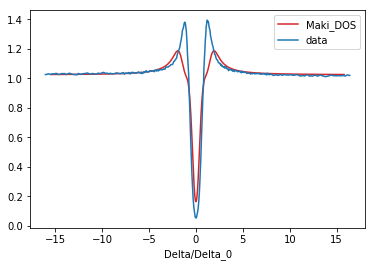

In [9]:
h = (600 * 1E-3)*5.78838E-5 / dimensionfulDelta

fit_class = FIT_class('data/600mT.txt',kT,dimensionfulDelta,h)

#alphaorb=0.1; betaSOC=1
didv_data, didv_maki = fit_class.get_didv_curves([0.1, 1])

fig, ax = plt.subplots()
plt.plot(didv_maki[0], didv_maki[1] , label='Maki_DOS', color=cp[3])
plt.plot(didv_data[0]/dimensionfulDelta, didv_data[1], label='data',color=cp[0])
plt.legend()
ax.set_xlabel('Delta/Delta_0')

__Plot the best-fit di/dv results ($\alpha_o = 0.117$ and $b = 6$). $b>1$ indicates a large spin-mixing rate relative to the energy scale associated with forming the superconducting condensate.__

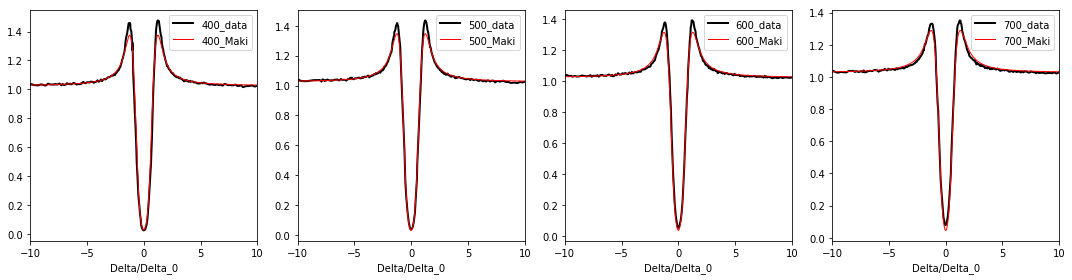

In [10]:
data_to_fit = [400,500,600,700] # Magnetic fields in mT
alphaorb = 0.117
betaSOC = 6

fig, axes = plt.subplots(1,len(data_to_fit), figsize=(15,4))
for i, h_i in enumerate(data_to_fit):
    path = 'data/' + str(h_i) + 'mT.txt'
    h = (h_i * 1E-3)*5.78838E-5 / dimensionfulDelta
    fit_class = FIT_class(path,kT,dimensionfulDelta,h)
    didv_data, didv_maki = fit_class.get_didv_curves([alphaorb, betaSOC])

    axes[i].plot(didv_data[0]/dimensionfulDelta, didv_data[1], label=str(h_i)+'_data', lw=2, color='black')
    axes[i].plot(didv_maki[0], didv_maki[1], label=str(h_i)+'_Maki', lw=1, color='red')
    axes[i].set_xlabel('Delta/Delta_0')
    axes[i].legend()
    axes[i].set_xlim((-10,10))
    
plt.tight_layout()

__Plot an example of a bad Maki fit ($\alpha_o = 0.1$ and $b = 0$). An example DOS if there wass no Spin orbit coupling.__

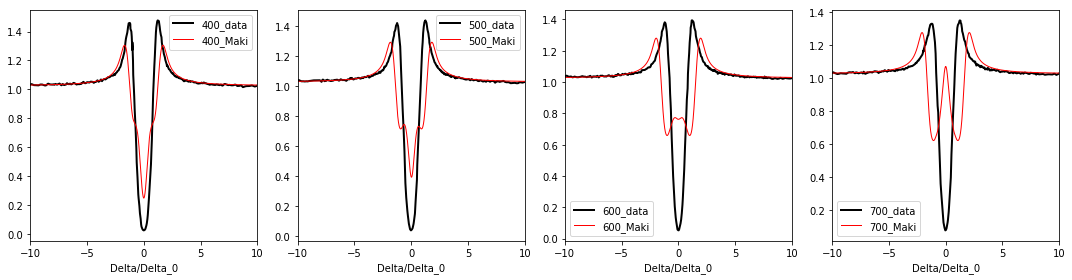

In [11]:
data_to_fit = [400,500,600,700]
alphaorb = 0.1
betaSOC = 0

fig, axes = plt.subplots(1,len(data_to_fit), figsize=(15,4))
for i, h_i in enumerate(data_to_fit):
    path = 'data/' + str(h_i) + 'mT.txt'
    h = (h_i * 1E-3)*5.78838E-5 / dimensionfulDelta
    fit_class = FIT_class(path,kT,dimensionfulDelta,h)
    didv_data, didv_maki = fit_class.get_didv_curves([alphaorb, betaSOC])

    axes[i].plot(didv_data[0]/dimensionfulDelta, didv_data[1], label=str(h_i)+'_data', lw=2, color='black')
    axes[i].plot(didv_maki[0], didv_maki[1], label=str(h_i)+'_Maki', lw=1, color='red')
    axes[i].set_xlabel('Delta/Delta_0')
    axes[i].legend()
    axes[i].set_xlim((-10,10))
    
plt.tight_layout()

__Plot example $\chi^2$ results for a single set of coupled orbital and spin-orbit depairing parameters.__

In [12]:
fit_class = FIT_class('data/500mT.txt',kT,dimensionfulDelta,h)


alphaorb = 0.1
betaSOC = [3,4,5,6,7,8,9,10,11,12]
chi_sq = []

#print('\n===========PRINTING ITERATION RESULTS============')

for i, b_i in enumerate(betaSOC):
    h = (500 * 1E-3)*5.78838E-5 / dimensionfulDelta
    fit_class = FIT_class('data/500mT.txt',kT,dimensionfulDelta,h)
    x2 = fit_class.chi_squared_result([alphaorb, b_i])
    chi_sq.append(x2)

#    print('betaSOC = {0:12.10E}'.format(b_i))
#    print('Chi Squared = {0:12.10E}'.format(x2))
#    print('\n')
#print('\n================DONE=================')


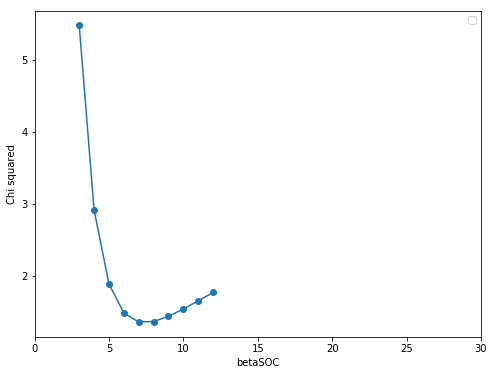

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(betaSOC, chi_sq, '-o')

ax.set_xlabel('betaSOC')
ax.set_ylabel('Chi squared')
ax.set_xlim((0,30))
#ax.set_ylim((0,15))
ax.legend()

Here I have just plotted a few examples with the main purpose of demonstrating how the FIT_class object can be used to show different Maki DOS and compare them with the experimental results. In the manuscript, we have first used a spin-independent version of Maki's theory to identify the $\alpha_i$ intercept. We then fit the data at several magnetic fields and calculate the combined MSE accross all of the fields. The results of which are shown below. 

<img src="MSE1.png" width="800"> 